# Basics of image de-blurring
Blur filters are low pass filters, they remove high frequency components which are usually associated with noise. Low pass filters applied to images makes them look bury. A pixel is blurred by taking the average over the surrounding pixels. Doing this for each pixel individually is slow but can be sped up using convolution.

## Contents
- Image noise
- How convolution can be used to speed up image filtering?
- The process which noise and blur effect images
- Convolution and de-convolution to blur and de-blur images
- De-convolution in de-blur noisy images


In [1]:
from torchvision import transforms
import torch
from PIL import Image
import matplotlib.pyplot as plt

## Load images

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

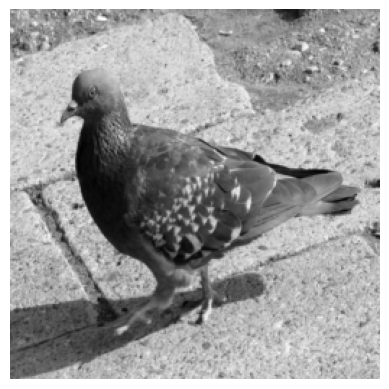

In [2]:
# Load images
folder = 'Images/'
device = 'cpu'
image = 'pigeon.jpeg'

image_path = folder + image  # Replace with your image path
image = Image.open(image_path)
transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((256, 256)), # Resize to 256x256 to speed up processing
        transforms.ToTensor()  
    ])
img_tensor = transform(image).squeeze()  # Remove channel dimension

# Display the image
plt.imshow(img_tensor, cmap='gray')
plt.axis('off')


## Shot noise (poisson noise)
Occurs when there is a finite number of particles that carry energy, such as photons in an image sensor or electrons in a circuit. Shot noise is one of the main types of noise that degrade image quality. 

Shot noise follows a Poisson distribution because:

1. **Discrete countable events**: Each photon arrival is a discrete, countable event
2. **Constant Average Rate $\lambda$**: The average rate of photon arrivals depends on the light intensity (brighter = more photons per second)
3. **No simultaneous Events**: In any tiny time interval, the probability of a photon arriving is very small. In an infinitesimally small window the probability of more than one event occuring is $\approx 0$
4. **Independent**: Previous photon arrivals don't affect future arrivals

These conditions exactly match the assumptions of a Poisson process. The number of photons detected in a fixed time period ($\Delta t$) follows:

$$P(k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

Where:
- $k$ = number of photons detected
- $\lambda$ = average number of photons arriving in $\Delta t$ (proportional to light intensity)
- Higher $\lambda$ = brighter pixel = more photons = less relative noise 
- Lower $\lambda$ = darker pixel = fewer photons = more relative noise

This is why images taken in low light (few photons) are much noisier than images in bright light (many photons).

## Method
- The number of photons in each pixel was simulated depending on the brightness of the pixel and its scale factor ($s$).
- The photon count was set as the expected number of photons in the pixel $sP(x)$
- `torch.poisson` randomly generates the number of photons present due to random variation


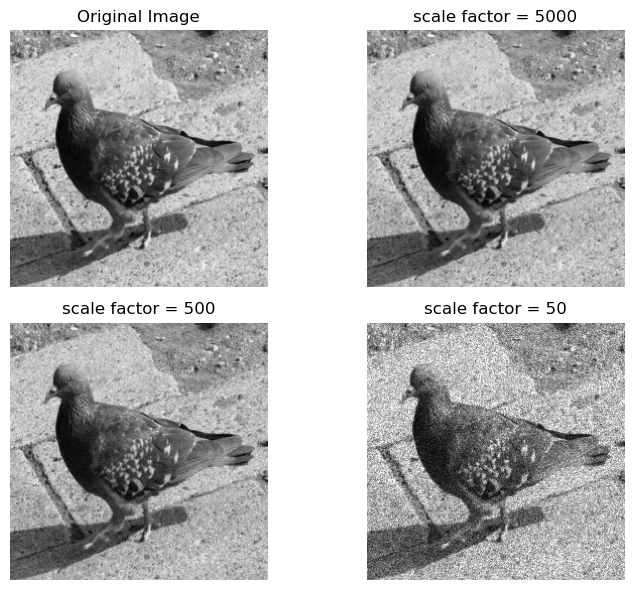

In [3]:
def add_poisson_noise(image, scale_factor=1000):
    """
    Add realistic Poisson (shot) noise to an image
    
    Args:
        image: Input tensor in range [0,1]
        scale_factor: Higher values = less noise (more photons)
    """
    # Convert to photon counts (scale up to simulate photon detection)
    photon_counts = image * scale_factor
    
    # Apply Poisson noise 
    noisy_photons = torch.poisson(photon_counts)
    
    # Convert back to [0,1] range
    noisy_image = noisy_photons / scale_factor
    
    return torch.clamp(noisy_image, 0, 1)

# Create noisy images with different noise levels
torch.manual_seed(42)  

# Low noise (high photon count)
noisy_low = add_poisson_noise(img_tensor, scale_factor=5000)

# Medium noise 
noisy_medium = add_poisson_noise(img_tensor, scale_factor=500)

# High noise (low photon count - like low light)
noisy_high = add_poisson_noise(img_tensor, scale_factor=50)

# Display results
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax[0,0].imshow(img_tensor, cmap='gray')
ax[0,0].set_title('Original Image')
ax[0,0].axis('off')

ax[0,1].imshow(noisy_low, cmap='gray')
ax[0,1].set_title('scale factor = 5000')
ax[0,1].axis('off')

ax[1,0].imshow(noisy_medium, cmap='gray')
ax[1,0].set_title('scale factor = 500')
ax[1,0].axis('off')

ax[1,1].imshow(noisy_high, cmap='gray')
ax[1,1].set_title('scale factor = 50')
ax[1,1].axis('off')

plt.tight_layout()
plt.show()

## Results
- The smaller the scale factor (number of photons) the noisier the image, which in reality is what happens.
- A key property of a poisson distribution is that the mean and variance are both $\lambda$. Increasing $s$ increases $\lambda$ and therefore should increase the absolute noise. The relative noise decreases, this is clear from looking at the signal to noise ratio $R$
$$R = \frac{\text{noise}}{\text{signal}} = \frac{\sqrt{\lambda}}{\lambda} = \frac{1}{\sqrt{\lambda}}$$
- This explains why higher photon counts produce clearer images.

## Filtering in 2D
Filtering in 2D works by acting a discrete function q (dimensions $X$, $M$) on an underlying image p:
$$p'(x,y) = \sum_{n=-X}^{X} \sum_{m=-Y}^{Y} p(x+n,y+m) \cdot q(n,m)$$

## Filtering Example: The box filter
The box filter is a type of low pass filter which helps to remove noise and blurs images. It works by setting the pixel value $p_{x,y}$ to be the average of the $N$ pixels above it and $M$ pixels below it.

 $$\tag{1} p'(x,y) = \frac{1}{(2N+1)(2M+1)} \sum_{n=-N}^{N} \sum_{m=-M}^{M} p(x+n,y+m)$$

This algorithm is incredibly slow when implemented with nested loops since computing each pixel value has an efficiency of $\mathbb{O}(N^2)$ which for the overall image will have efficiency $\mathbb{O}(N^4)$, since each pixel needs to be filtered in the $x$ and $y$ direction. This can be rapidly increased using convolution.

## Convolution
The convolution of two functions is given by the multiplication of the fourier transforms. The convolution theorem states that the convolution of two functions $v(x)$ and $u(x)$ can be given in terms of their fourier transforms $V(k)$ and $U(k)$ respectively:

$$f(x) = v(x) * u(x) = \mathcal{F}^{-1}\{V(k) \cdot U(k)\} \tag{2}$$

Where:
- $*$ denotes convolution
- $\mathcal{F}^{-1}$ is the inverse Fourier transform
- $\cdot$ denotes pointwise multiplication
Convolution in spatial domain is the same as multiplication in frequency domain. The convolution method can greatly improve the efficiency of applying filters especially when using the fast fourier transform. The nested loop approach has efficiency $\mathbb{O}(N^4)$ ($\mathbb{O}(N^2)$ per pixel) where as transfering to the frequency domain increases the efficency to $\mathbb{O}(N^2) \log(N)$ ($\mathbb{O}(\log{N})$ per pixel). Furthermore there are advantages to using the better optimized pytorch tensors compared to using inefficient python loops.
Convolution corresponds to numerically represents multiplication of every value in the list $v(x)$ with every value in the list $u(x)$.

### The box filter
The box function is the "convolution kernel" for this type of filter, which describes which surrounding pixel values will be used to form the filtered pixel value $p'_{x,y}$. It is described as:

$$\text{box}_{N,M}(n,m) = \begin{cases} 
\frac{1}{(2N+1)(2M+1)} & \text{if} -N \leq n \leq N \text{ and} - M \leq m \leq M \\
0 & \text{else}
\end{cases}$$

e.g.

$$\text{box}_{2,2}(n,m) = $$

To blur the image the the box function is applied to the image using convolution.

$$p'(x,y) = p(x,y) * \text{box}_{N,M}(x,y)$$
or generally
$$p'(x,y) = p(x,y) * q(x,y)$$

#### Creating box functions
Different shapes of box functions were created and there bluing effects were analyzed.


In [4]:
def box_function(N, M):
    kernel = torch.ones(1, 1, N, M) / (N * M)
    return kernel

val = 5
square_kernel = box_function(val, val)
horizontal_kernel = box_function(1, val)
vertical_kernel = box_function(val, 1)

#### Carry out convolution
$$p'(x,y) = p(x,y) * \text{box}_{N,M}(x,y)$$

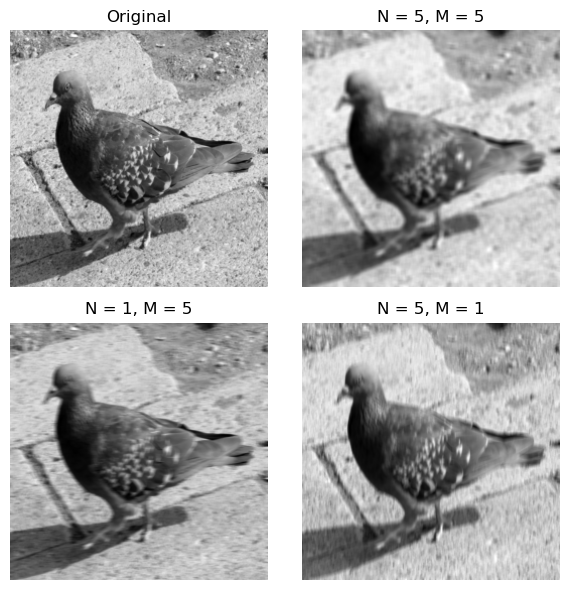

In [5]:
import torch.nn.functional as F

def convolution(image, kernel, padding_mode='zeros'):    
    # Apply convolution with padding to maintain image size
    padding = (kernel.size(2) // 2, kernel.size(3) // 2)
    if padding_mode == 'zeros':
        filtered = F.conv2d(image.unsqueeze(0).unsqueeze(0), kernel, padding=padding)
    elif padding_mode == 'circular':
        image_padded = torch.cat([image[:, -padding[0]:], image, image[:, :padding[0]]], dim=1)
        image_padded = torch.cat([image_padded[-padding[1]:, :], image_padded, image_padded[:padding[1], :]], dim=0)
        filtered = F.conv2d(image_padded.unsqueeze(0).unsqueeze(0), kernel, padding=0)
    elif padding_mode == 'reflect':
        image_padded = F.pad(image.unsqueeze(0).unsqueeze(0), (padding[1], padding[1], padding[0], padding[0]), mode='reflect')
        filtered = F.conv2d(image_padded, kernel, padding=0)
    elif padding_mode == 'replicate':
        image_padded = F.pad(image.unsqueeze(0).unsqueeze(0), (padding[1], padding[1], padding[0], padding[0]), mode='replicate')
        filtered = F.conv2d(image_padded, kernel, padding=0)
    elif padding_mode == None:
        filtered = F.conv2d(image.unsqueeze(0).unsqueeze(0), kernel)
    else:   
        raise ValueError(f"Unsupported padding mode: {padding_mode}")
    
    # Remove batch and channel dimensions: [1, 1, H, W] -> [H, W]
    return filtered.squeeze(0).squeeze(0)

fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax = ax.flatten()
ax[0].imshow(img_tensor, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

for i, kernel in enumerate([square_kernel, horizontal_kernel, vertical_kernel]):
    filtered_img = convolution(img_tensor, kernel, padding_mode='replicate')
    ax[i+1].imshow(filtered_img, cmap='gray')
    titles = [f'N = {val}, M = {val}', f'N = 1, M = {val}', f'N = {val}, M = 1']
    ax[i+1].set_title(titles[i])
    ax[i+1].axis('off')
fig.tight_layout()

#### Discussion
- The results show that the square box filter causes equal bluing in both directions.
- The horizontal box filter causes bluing in only the horizontal direction.
- Similarly for the vertical box filter.

## De-convolution

The images can be de-blurred via de-convolution using the convolution kernel. De convolution is working out $v(x)$ knowing $f(x)$ and $u(x)$ given $f(x) = v(x) * u(x)$ . The inverse (de-convolution) is:
$$v(x) = \mathcal{F}^{-1}\left\{\frac{F(k)}{H(k)}\right\} \tag{3}$$
Since the convolution kernel for the blured images is known the original image can be recovered.
$$p(x,y) = \mathcal{F}^{-1}\left\{\frac{P'(u,v)}{B(u,v)}\right\} \tag{4}$$

Where:
- $B(k) = \mathcal{F}\{h(x)\}$ is the Fourier transform of the blur kernel in this case the fourier transform of the box function
- $P'(u,v) = \mathcal{F}\{p'(x,y)\}$ is the Fourier transform of the blurred image

## Convolving and then de-convolving the image
- The image is first blurred using convolution with the box function
- The blurred image is then de-blurred using de-convolution with the box function

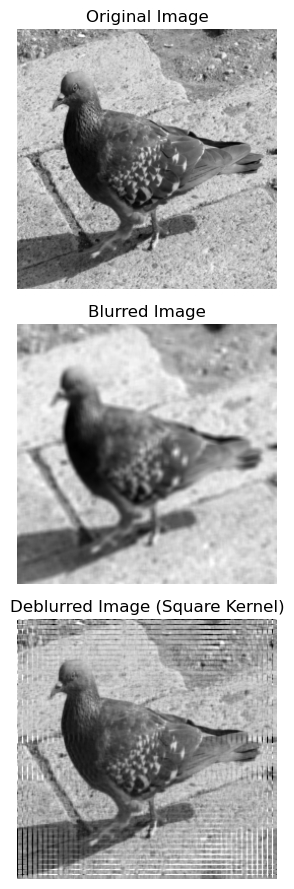

In [6]:
def deconvolution(blurred_image, kernel, epsilon=1e-5):
    # Compute Fourier transforms
    P_blurred = torch.fft.fft2(blurred_image)
    B = torch.fft.fft2(kernel.squeeze(), s=blurred_image.shape)
    
    # Avoid division by zero by adding a small constant (epsilon)
    B_conj = torch.conj(B)
    B_magnitude_squared = torch.abs(B)**2
    B_inv = B_conj / (B_magnitude_squared + epsilon)
    
    # Perform deconvolution in the frequency domain
    P_deblurred = P_blurred * B_inv

    # Inverse Fourier transform to get the deblurred image
    deblurred_image = torch.fft.ifft2(P_deblurred).real
    
    return torch.clamp(deblurred_image, 0, 1)

square_kernel = box_function(5, 5)
square_blured = convolution(img_tensor, square_kernel, padding_mode='replicate')
deblurred_img = deconvolution(square_blured, square_kernel, epsilon=1e-3)
fig, ax = plt.subplots(3, 1, figsize=(3, 9))
ax[0].imshow(img_tensor, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(square_blured, cmap='gray')
ax[1].set_title('Blurred Image')
ax[1].axis('off')

ax[2].imshow(deblurred_img, cmap='gray')
ax[2].set_title('Deblurred Image (Square Kernel)')
ax[2].axis('off')

fig.tight_layout()


## Discussion
- The deconvolution process is not perfect. Artifacts are introduced in the image, especially around the edges potentially due to boundary effects and noise amplification.
- Furthermore, the box filter is not a perfect low-pass filter. While it should attenuate higher frequencies, this doesn't always work due to its frequency response characteristics.
- **Counter-example**: A high frequency alternating signal $p(x) = [..., 1, -1, 1, -1, 1, ...]$ convolved with a 1×1 box filter:
  $$p'(x) = p(x) * \text{box}_1(x)$$
  The high frequency signal passes through unchanged.
- **Example of lower frequency attenuation**: A lower frequency signal $p(x) = [..., 1, -0.5, -0.5, 1, -0.5, -0.5, ...]$ when convolved with $\text{box}_1$ gives $\mathbb{0}$, showing selective frequency attenuation.
- Box filters give each pixel within the "box" equal weighting. In reality pixels closer to the middle will have larger weighting
- Convolving a box filter on a box filter does not give a box filter. This is a problem since applying a box filter twice isn't doubling the amount of "blur".
- Division by small values in $H(k)$ can amplify noise and introduce artifacts. Especially as the box filter may attenuate certain frequencies to near zero.

## Padding
Padding is likely the cause of some of the artifacts seen in the de-blurred images. When convolving near the edges of an image, there are not enough surrounding pixels to apply the filter properly. Padding adds extra pixels around the border of the image to mitigate this issue. In this case 


## Gaussian filters
The gaussian filter is defined in 1 dimension as:
$$g_{\sigma}(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{x^2}{2\sigma^2}}$$
or in 2 dimensions as:
$$g_{\sigma}(x,y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2+y^2}{2\sigma^2}}$$
Where $\sigma$ is the standard deviation which controls the width of the gaussian. The larger the $\sigma$ the wider the gaussian and therefore the more blurring that occurs. The gaussian filter is a better low-pass filter than the box filter since it gives more weighting to pixels closer to the center. 

## Image Degrading
images become degraded by convolving the image with a guassian kernel then adding noise.
$$d(x,y) = p(x,y) * q(x,y) + n(x,y)$$
then an attempt to recover the original image was made using
$$p(x,y) = d(x,y) / q(x,y) = \mathcal{F}^{-1}\left\{\frac{D(x,y)}{Q(x,y)}\right\} \tag{4}$$

In [7]:
def gaussian_normalised_kernel(size, sigma):
    """Generate a 2D Gaussian kernel."""
    ax = torch.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / torch.sum(kernel)
    return kernel.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, size, size]

gaussian_kernel1 = gaussian_normalised_kernel(size=10, sigma=2.0)
gaussian_blured1 = convolution(img_tensor, gaussian_kernel1, padding_mode = "replicate")
degraded_gaussian_blured1 = add_poisson_noise(gaussian_blured1, scale_factor=500)
deblurred_gaussian1 = deconvolution(degraded_gaussian_blured1, gaussian_kernel1, epsilon=1e-3)

gaussian_kernel2 = gaussian_normalised_kernel(size=5, sigma=1.0)
gaussian_blured2 = convolution(img_tensor, gaussian_kernel2, padding_mode = "replicate")
degraded_gaussian_blured2 = add_poisson_noise(gaussian_blured2, scale_factor=500)
deblurred_gaussian2 = deconvolution(degraded_gaussian_blured2, gaussian_kernel2, epsilon=1e-3)

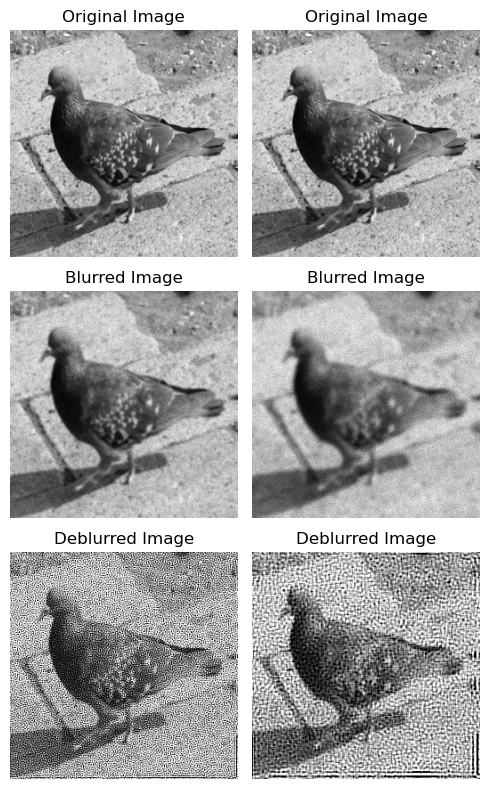

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(5, 8))
ax[0, 1].imshow(img_tensor, cmap='gray')
ax[0, 1].set_title('Original Image')
ax[0, 1].axis('off')

ax[1, 1].imshow(degraded_gaussian_blured1, cmap='gray')
ax[1, 1].set_title('Blurred Image')
ax[1, 1].axis('off')

ax[2, 1].imshow(deblurred_gaussian1, cmap='gray')
ax[2, 1].set_title('Deblurred Image')
ax[2, 1].axis('off')

ax[0, 0].imshow(img_tensor, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[1, 0].imshow(degraded_gaussian_blured2, cmap='gray')
ax[1, 0].set_title('Blurred Image')
ax[1, 0].axis('off')

ax[2, 0].imshow(deblurred_gaussian2, cmap='gray')
ax[2, 0].set_title('Deblurred Image')
ax[2, 0].axis('off')
fig.tight_layout()

(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

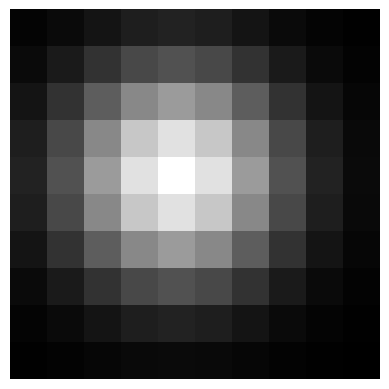

In [9]:
fig, ax = plt.subplots()
ax.imshow(gaussian_kernel1.squeeze(), cmap='gray')
ax.axis('off')

## Discussion
- The de-bluring from the gaussian filters is significantly better than the box filter, especially for the heavily blured image.
- There are some edge artifacts present in the de-blured images, but not as bad as the box filter.
- This seems to be related to kernel size since larger kernels produce more edge artifacts
- This could be because the code assumes that the image is infinately periodic.

## Realistic noise
Realistically noise and blur occur together. This time an image will be blured using the gaussian filter and then poisson noise will be added, to simulate realistic image acquisition conditions. The image will then be de-blured, using the convolution kernel.

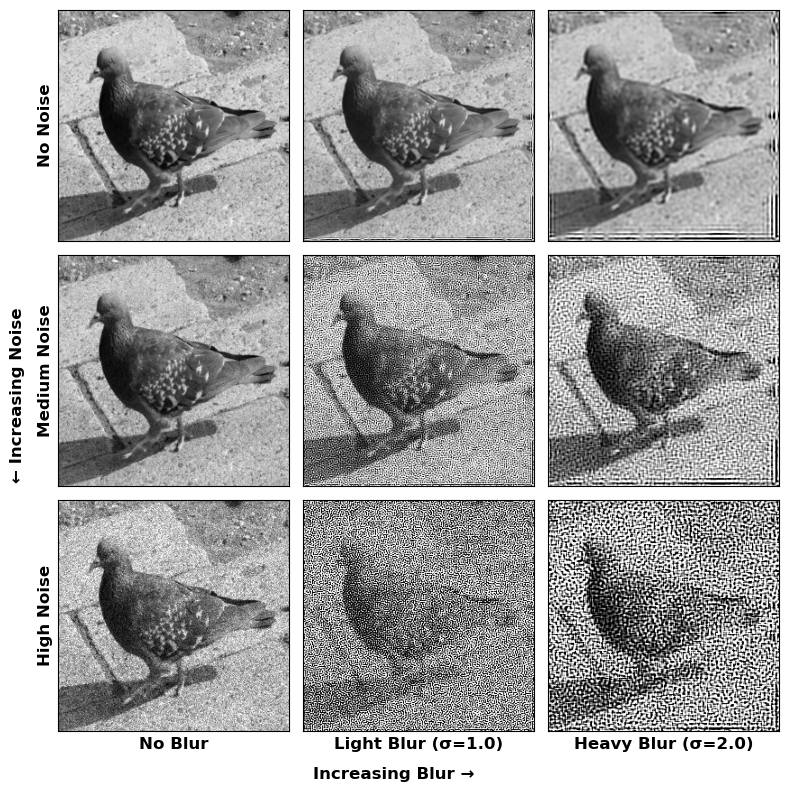

In [10]:
# Using your existing variables

gaussian_kernel3 = gaussian_normalised_kernel(size=5, sigma=0.5)
no_blur_kernel = torch.tensor([[[[1.0]]]])  # Identity kernel for no blur

blur_levels =  [(no_blur_kernel, 'No Blur'),
                (gaussian_kernel2, 'Light Blur (σ=1.0)'), 
                (gaussian_kernel1, 'Heavy Blur (σ=2.0)')]
noise_levels = [(50000000, 'No Noise'), (500, 'Medium Noise'), (50, 'High Noise')]

fig, axes = plt.subplots(len(noise_levels), len(blur_levels), figsize=(8, 8))

for i, (noise_scale, noise_label) in enumerate(noise_levels):
    for j, (kernel, blur_label) in enumerate(blur_levels):
        # Blur then add noise
        blurred = convolution(img_tensor, kernel, padding_mode='replicate')
        noisy_blurred = add_poisson_noise(blurred, scale_factor=noise_scale)
        if kernel.equal(no_blur_kernel):
            deblured = noisy_blurred 
        else:
            deblured = deconvolution(noisy_blurred, kernel, epsilon=1e-3)
        axes[i, j].imshow(deblured, cmap='gray')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        if i == 2:
            axes[i, j].set_xlabel(blur_label, fontsize=12, fontweight='bold')
        if j == 0:
            axes[i, j].set_ylabel(noise_label, fontsize=12, fontweight='bold')
        

fig.text(0.5, 0.02, 'Increasing Blur →', ha='center', fontsize=12, fontweight='bold')
fig.text(0.02, 0.5, '← Increasing Noise', va='center', rotation=90, fontsize=12, fontweight='bold')

fig.tight_layout()
plt.subplots_adjust(bottom=0.08, left=0.08)
fig.savefig('deblurring_results.png', dpi=500)


## Discussion
- Blur on its own can be successfully removed using de convolution. 
- However when noise is added the de convolution process generates artifacts which makes it even more difficult to recover the original image.
- After noise present after the de convolution process is no longer random but seems to have more structure than the original noise since there are more distinct patches of black and white.
- This noise due to noise and blur is more visually disturbing than noise or blur.

## Summary
De convolution was used to de blur images which had been convolved with a known kernel. This worked very well for images which had been blurred but not corrupted with noise. But realistically acquired images will be blurred and will have noise on top of this. De convoluting the noisy images did not work well and created artifacts in the image, which was visually more disturbing than gaussian noise.


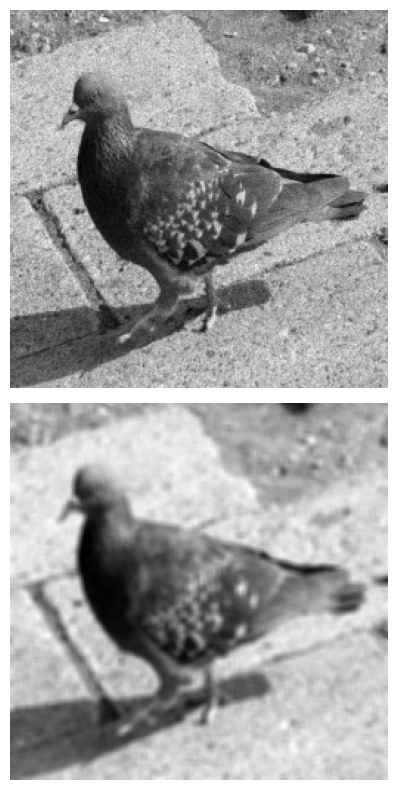

In [11]:
noisy_img_tensor = add_poisson_noise(img_tensor, scale_factor=500)
blurred_noisy_img = convolution(noisy_img_tensor, box_function(5,5), padding_mode='replicate')
fig, ax = plt.subplots(2, 1, figsize=(5, 8))
ax[0].imshow(noisy_img_tensor, cmap='gray')

ax[0].axis('off')
ax[1].imshow(blurred_noisy_img, cmap='gray')

ax[1].axis('off')

fig.tight_layout()
fig.savefig('noisy_blurred_image.png', dpi=500)